In [1]:
!pip install darts
!pip install utils
!pip install optuna

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
import optuna

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
file_path = 'processed_dataset(3).csv'
data = pd.read_csv(file_path)

data = data.set_index('Date')
data.index = pd.to_datetime(data.index)

In [5]:
split_date = pd.to_datetime('2008-12-31 23:59')
data = data[data.index >= split_date]

In [6]:
# data['Temperature t+24'] = data['Temperature'].shift(periods=-24)
# data['Humidity t+24'] = data['Humidity'].shift(periods=-24)
data['Year'] = data.index.year
# data['Year t+24'] = data['Year'].shift(periods=-24)
data['Month'] = data.index.month

In [7]:
data_sin = data[['SIN']]
data_cov = data[['Temperature', 'Humidity', 'Year', 'Month']]

In [8]:
series = TimeSeries.from_dataframe(data_sin, value_cols=["SIN"])
covariates = TimeSeries.from_dataframe(data_cov, value_cols=["Temperature", "Humidity", "Year", "Month"])
series = series.astype(np.float32)
covariates = covariates.astype(np.float32)

In [54]:
covariates['Temperature']

<TimeSeries (DataArray) (Date: 122712, component: 1, sample: 1)>
array([[[26.749483]],

       [[26.485027]],

       [[26.22057 ]],

       ...,

       [[38.219105]],

       [[35.7266  ]],

       [[33.234097]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 2009-01-01 ... 2022-12-31T23:00:00
  * component  (component) object 'Temperature'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

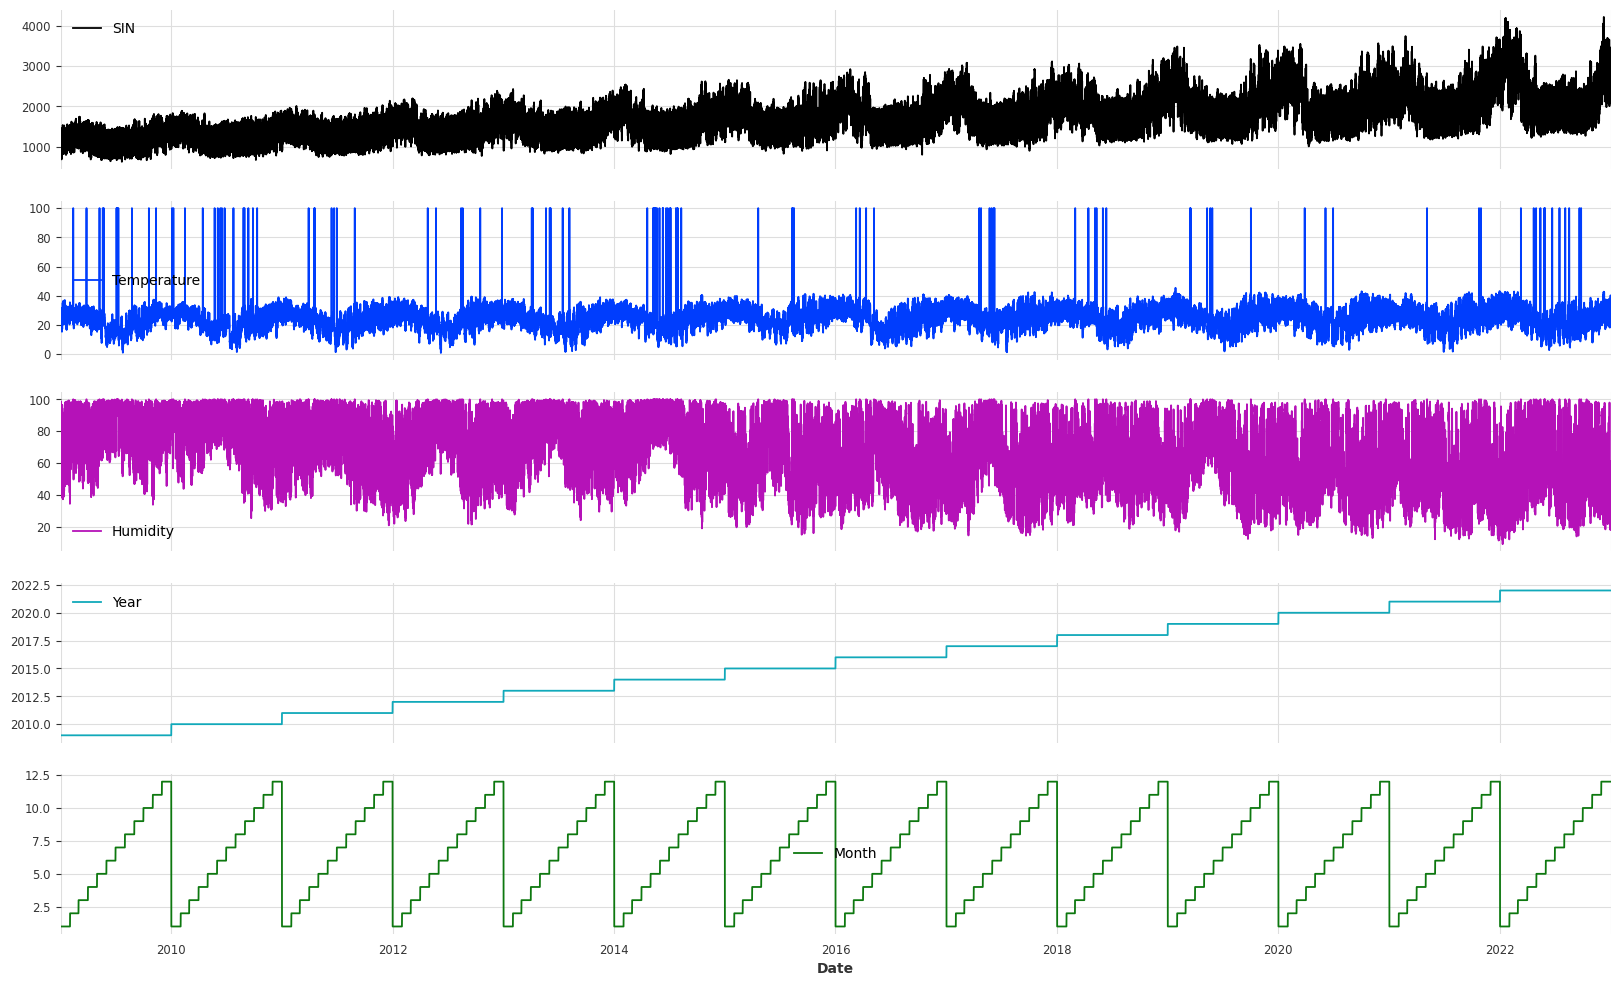

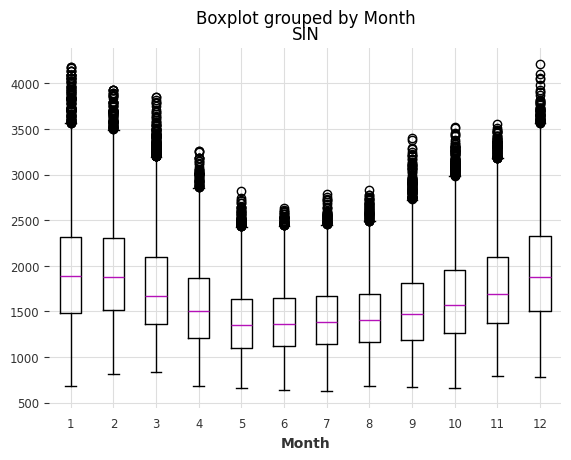

In [36]:
# Time series plots for each column
data.plot(subplots=True, layout=(5,1), figsize=(20, 12))
plt.show()

# Box plot for SIN by month to observe seasonality and outliers
data.boxplot(column='SIN', by='Month')
plt.show()

In [9]:
# # Create training and validation sets:
training_cutoff = pd.Timestamp("20191231T230000")
train, val = series.split_after(training_cutoff)
# validation_cutoff = pd.Timestamp("20220131T230000")
# val, not_used = val.split_after(validation_cutoff)

In [44]:
print(val)

<TimeSeries (DataArray) (Date: 26304, component: 1, sample: 1)>
array([[[2195.]],

       [[2254.]],

       [[2308.]],

       ...,

       [[3454.]],

       [[3120.]],

       [[2922.]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 2020-01-01 ... 2022-12-31T23:00:00
  * component  (component) object 'SIN'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [10]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [11]:
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)
cov_train, cov_val = covariates.split_after(training_cutoff)
cov_val, not_used = cov_val.split_after(validation_cutoff)

NameError: name 'validation_cutoff' is not defined

In [12]:
# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
covariates_transformed_train = scaler_covs.fit_transform(cov_train)
covariates_transformed_val = scaler_covs.transform(cov_val)
covariates_transformed = scaler_covs.transform(covariates)

In [48]:
from darts.models import TFTModel, ARIMA, RNNModel
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanAbsolutePercentageError

# torch_metrics = MeanAbsolutePercentageError()

# early stop callback
my_stopper = EarlyStopping(
    monitor="train_loss",  # "val_loss",
    patience=20,
    min_delta=0.025,
    mode='min',
)
pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0],
      "callbacks": [my_stopper]
}

# early_stopping = EarlyStopping(patience=5, monitor='val_loss')
# Train TFT
# tft = TFTModel(input_chunk_length=365, output_chunk_length=24)
tft = TFTModel(
    input_chunk_length=336,
    output_chunk_length=24,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=100,
    add_relative_index=False,
    add_encoders=None,
    # loss_fn=MSELoss(),
    random_state=42,
    force_reset = True,
    save_checkpoints=True,
    # torch_metrics=torch_metrics,
    pl_trainer_kwargs=pl_trainer_kwargs,
)
tft.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

# Train ARIMA (it doesn't handle covariates)
arima = ARIMA()
arima.fit(train_transformed)

# Train LSTM
lstm = RNNModel(model='LSTM', input_chunk_length=336, output_chunk_length=24, n_epochs=100, random_state=42, dropout=0.2, batch_size=16)
lstm.fit(train_transformed, future_covariates=covariates_transformed_train, verbose=True)

# Train GRU
gru = RNNModel(model='GRU', input_chunk_length=336, output_chunk_length=24, n_epochs=100, random_state=42, dropout=0.2, batch_size=16)
gru.fit(train_transformed, future_covariates=covariates_transformed_train, verbose=True)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

RNNModel(model=GRU, hidden_dim=25, n_rnn_layers=1, dropout=0.2, training_length=24, input_chunk_length=336, output_chunk_length=24, n_epochs=100, random_state=42, batch_size=16)

In [14]:
# Save the trained TFT model
tft_model_path = "tft_model.pt"
tft.save(tft_model_path)

# Save the trained ARIMA model
arima_model_path = "arima_model.pt"
arima.save(arima_model_path)

# Save the trained LSTM model
lstm_model_path = "lstm_model.pt"
lstm.save(lstm_model_path)

# Save the trained GRU model
gru_model_path = "gru_model.pt"
gru.save(gru_model_path)

NameError: name 'tft' is not defined

In [16]:
from darts.models import TFTModel, ARIMA, RNNModel
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanAbsolutePercentageError

tft_model_path = "tft_model.pt"
tft = TFTModel.load(tft_model_path)

arima_model_path = "arima_model.pt"
arima = ARIMA.load(arima_model_path)

lstm_model_path = "lstm_model.pt"
lstm = RNNModel.load(lstm_model_path)

gru_model_path = "gru_model.pt"
gru = RNNModel.load(gru_model_path)

In [17]:
# Predictions for 2022 (24 hours ahead)
tft_pred = tft.predict(n=24, future_covariates=covariates_transformed)
arima_pred = arima.predict(n=24)
lstm_pred = lstm.predict(n=24, future_covariates=covariates_transformed)
gru_pred = gru.predict(n=24, future_covariates=covariates_transformed)

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [18]:
tft_pred = transformer.inverse_transform(tft_pred)
arima_pred = transformer.inverse_transform(arima_pred)
lstm_pred = transformer.inverse_transform(lstm_pred)
gru_pred = transformer.inverse_transform(gru_pred)


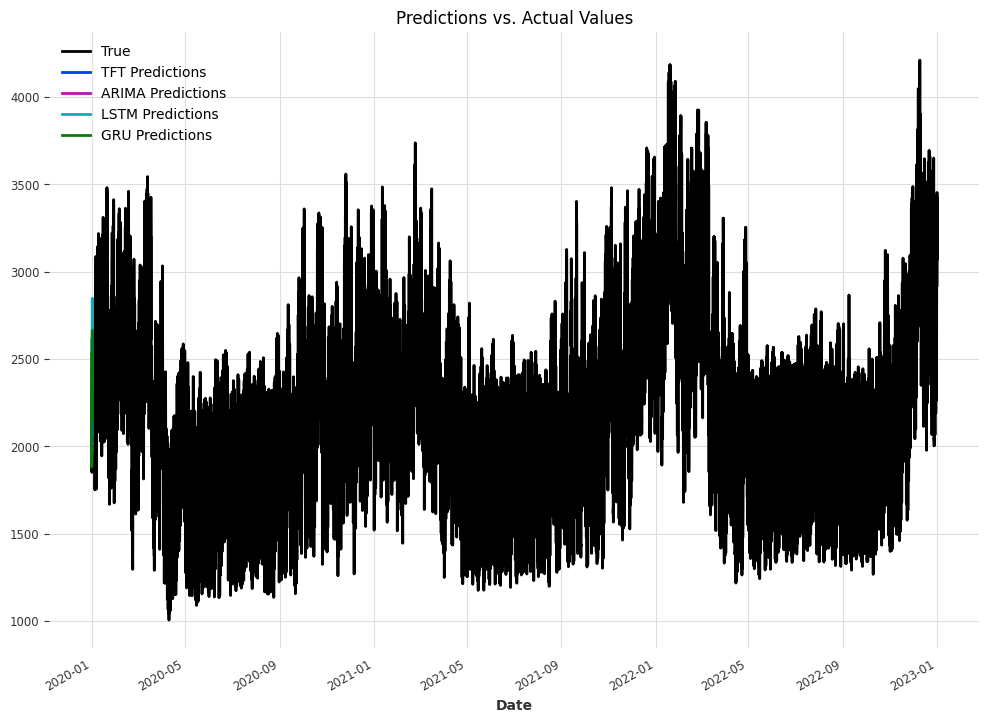

In [19]:
# Plotting model predictions
plt.figure(figsize=(12, 8))
val.plot(label='True', lw=2)
tft_pred.plot(label='TFT Predictions', lw=2)
arima_pred.plot(label='ARIMA Predictions', lw=2)
lstm_pred.plot(label='LSTM Predictions', lw=2)
gru_pred.plot(label='GRU Predictions', lw=2)
plt.title("Predictions vs. Actual Values")
plt.legend()
plt.show()

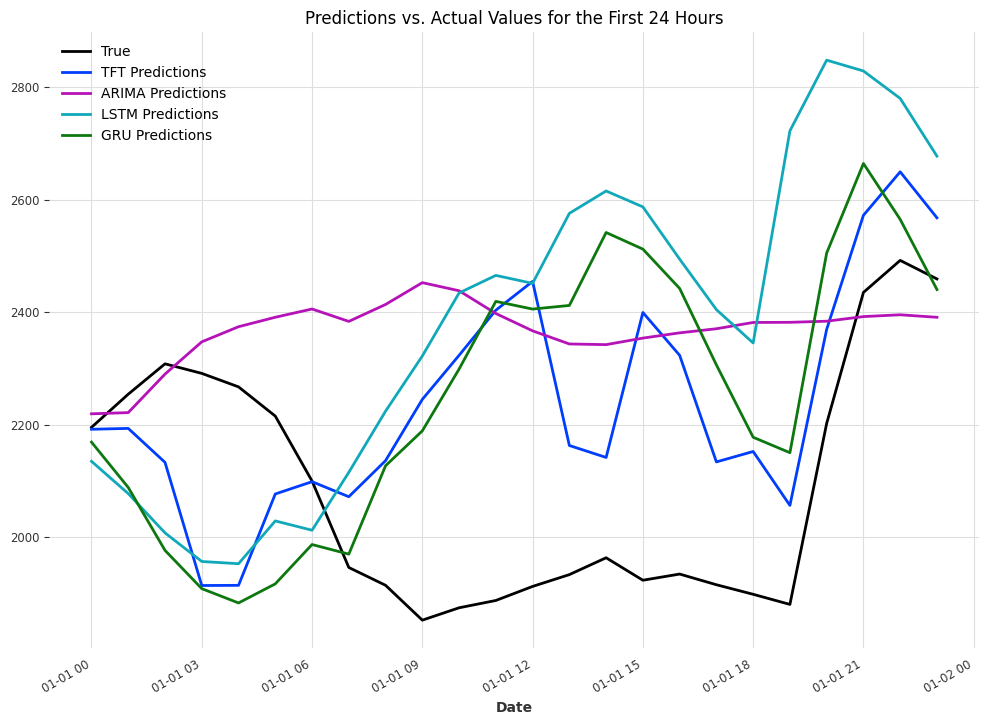

In [20]:
# Extracting the first 24 hours from actual and prediction data
valid_24h = val[:24]
tft_pred_24h = tft_pred[:24]
arima_pred_24h = arima_pred[:24]
lstm_pred_24h = lstm_pred[:24]
gru_pred_24h = gru_pred[:24]

# Plotting model predictions for the first 24 hours
plt.figure(figsize=(12, 8))
valid_24h.plot(label='True', lw=2)
tft_pred_24h.plot(label='TFT Predictions', lw=2)
arima_pred_24h.plot(label='ARIMA Predictions', lw=2)
lstm_pred_24h.plot(label='LSTM Predictions', lw=2)
gru_pred_24h.plot(label='GRU Predictions', lw=2)
plt.title("Predictions vs. Actual Values for the First 24 Hours")
plt.legend()
plt.show()







In [21]:
from darts.metrics import mape, mae, rmse

def compute_metrics(model_name, actual, predictions):
    return {
        'Model': model_name,
        'MAPE': mape(actual, predictions),
        'MAE': mae(actual, predictions),
        'RMSE': rmse(actual, predictions)
    }

metrics = pd.DataFrame([
    compute_metrics('TFT', val, tft_pred),
    compute_metrics('ARIMA', val, arima_pred),
    compute_metrics('LSTM', val, lstm_pred),
    compute_metrics('GRU', val, gru_pred)
])

print(metrics)

   Model       MAPE         MAE        RMSE
0    TFT  12.158036  243.811768  288.136780
1  ARIMA  15.530648  302.788173  362.404875
2   LSTM  20.565939  413.879852  461.406097
3    GRU  15.423974  310.228546  354.965240


In [22]:
n = len(val)  # Get the length of the validation dataset
tft_pred_val = tft.predict(n=n, future_covariates=covariates_transformed)
tft_pred_val = transformer.inverse_transform(tft_pred_val)

Predicting: 0it [00:00, ?it/s]

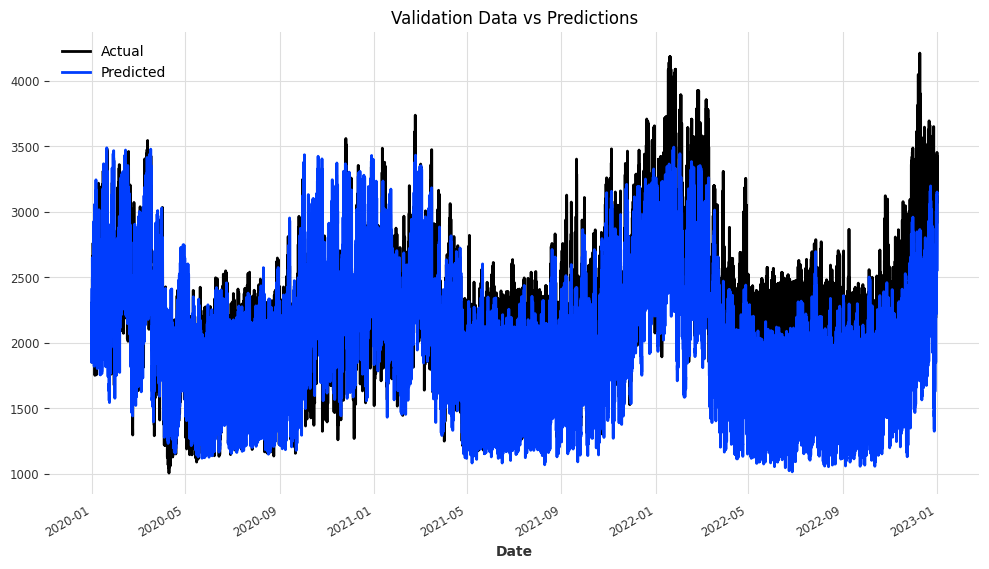

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
val.plot(label='Actual')
tft_pred_val.plot(label='Predicted')
plt.title('Validation Data vs Predictions')
plt.legend()
plt.show()

In [26]:
validation_range = ('2020-01-01', '2022-12-31')
dtin = pd.date_range(start=validation_range[0], end=validation_range[1], freq='H')

In [30]:
# Convert TimeSeries to numpy arrays
tft_pred_val_arr = tft_pred_val.values()
val_arr = val.values()

In [50]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error

ixmax=np.argmax(val_arr.reshape(-1,24),axis=1)
hmaxerr=((tft_pred_val_arr.reshape(-1,24)[np.arange(tft_pred_val_arr.reshape(-1,24).shape[0]),ixmax]-np.max(val_arr.reshape(-1,24),axis=1))/np.max(val_arr.reshape(-1,24),axis=1))
hsup=np.percentile(hmaxerr,99)
hinf=np.percentile(hmaxerr,1)
mse=mean_squared_error( val_arr, tft_pred_val_arr)
rmse=np.sqrt(mse)
error=np.abs(val_arr-tft_pred_val_arr)
Error_95_=np.percentile(error,95)
maxError_=max_error(val_arr, tft_pred_val_arr)

r2_=r2_score(val_arr, tft_pred_val_arr)
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  ))
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  )+" Error95:" + str(Error_95_))
print( "hsup: " + str(hsup)+" hinf:" + str(hinf))
print( "hmaxerr5: " + str(np.percentile(error,5)))
print( "hmaxerr50: " + str(np.percentile(error,50)))
print( "hmaxerr95: " + str(np.percentile(error,95)))

MSE: 146280.89 RMSE:382.46686
MaxError: 1873.9922 R2:0.49521223088041366 Error95:776.2103576660156
hsup: 0.129183867573738 hinf:-0.46469694972038267
hmaxerr5: 21.01142578125
hmaxerr50: 233.7457275390625
hmaxerr95: 776.2103576660156


In [51]:
hmaxerr = ((tft_pred_val_arr.reshape(-1, 24)[np.arange(tft_pred_val_arr.reshape(-1, 24).shape[0]), ixmax] - np.max(val_arr, axis=1)) / np.max(val_arr, axis=1))

ValueError: operands could not be broadcast together with shapes (1096,) (26304,) 

In [47]:
ixmax=np.argmax(val_arr.reshape(-1,24),axis=1)

In [49]:
print(val_arr)

[[2195.]
 [2254.]
 [2308.]
 ...
 [3454.]
 [3120.]
 [2922.]]


In [38]:
tft_pred_val_arr.size

26304

0.129183867573738
-0.18551041185855865
-0.46469694972038267
0.47027249485254285
0.25042086839675903
0.08031437247991562


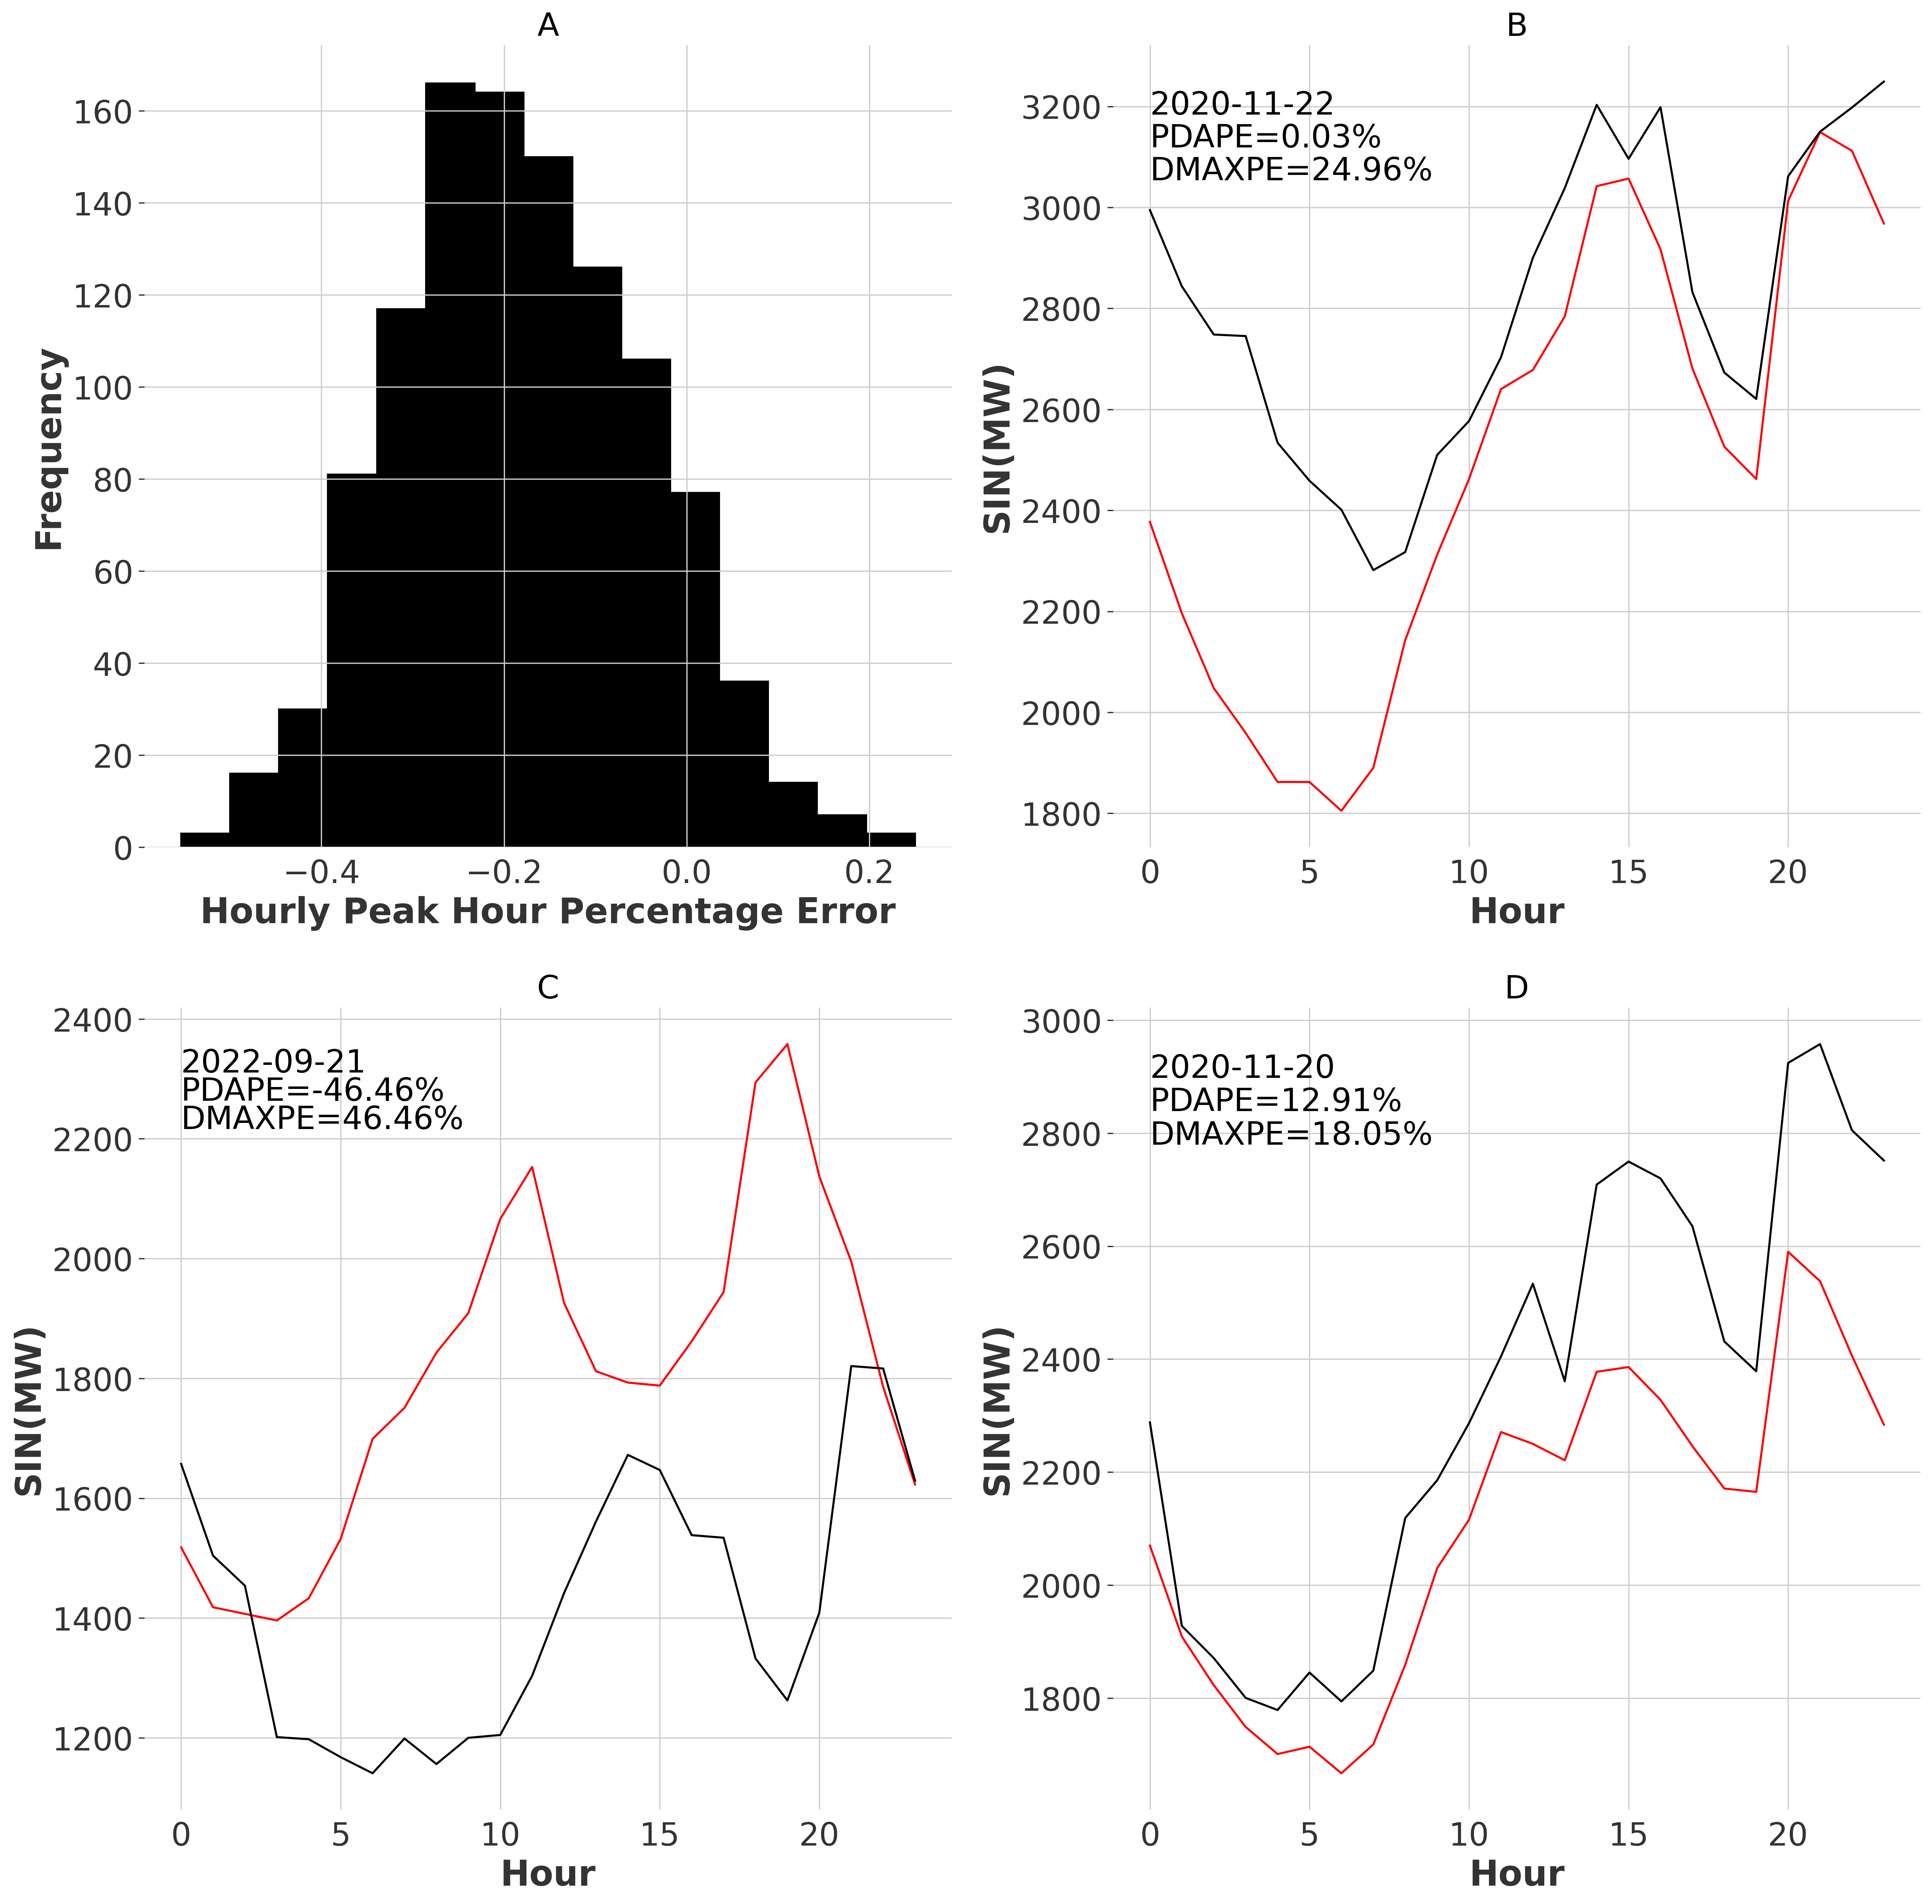

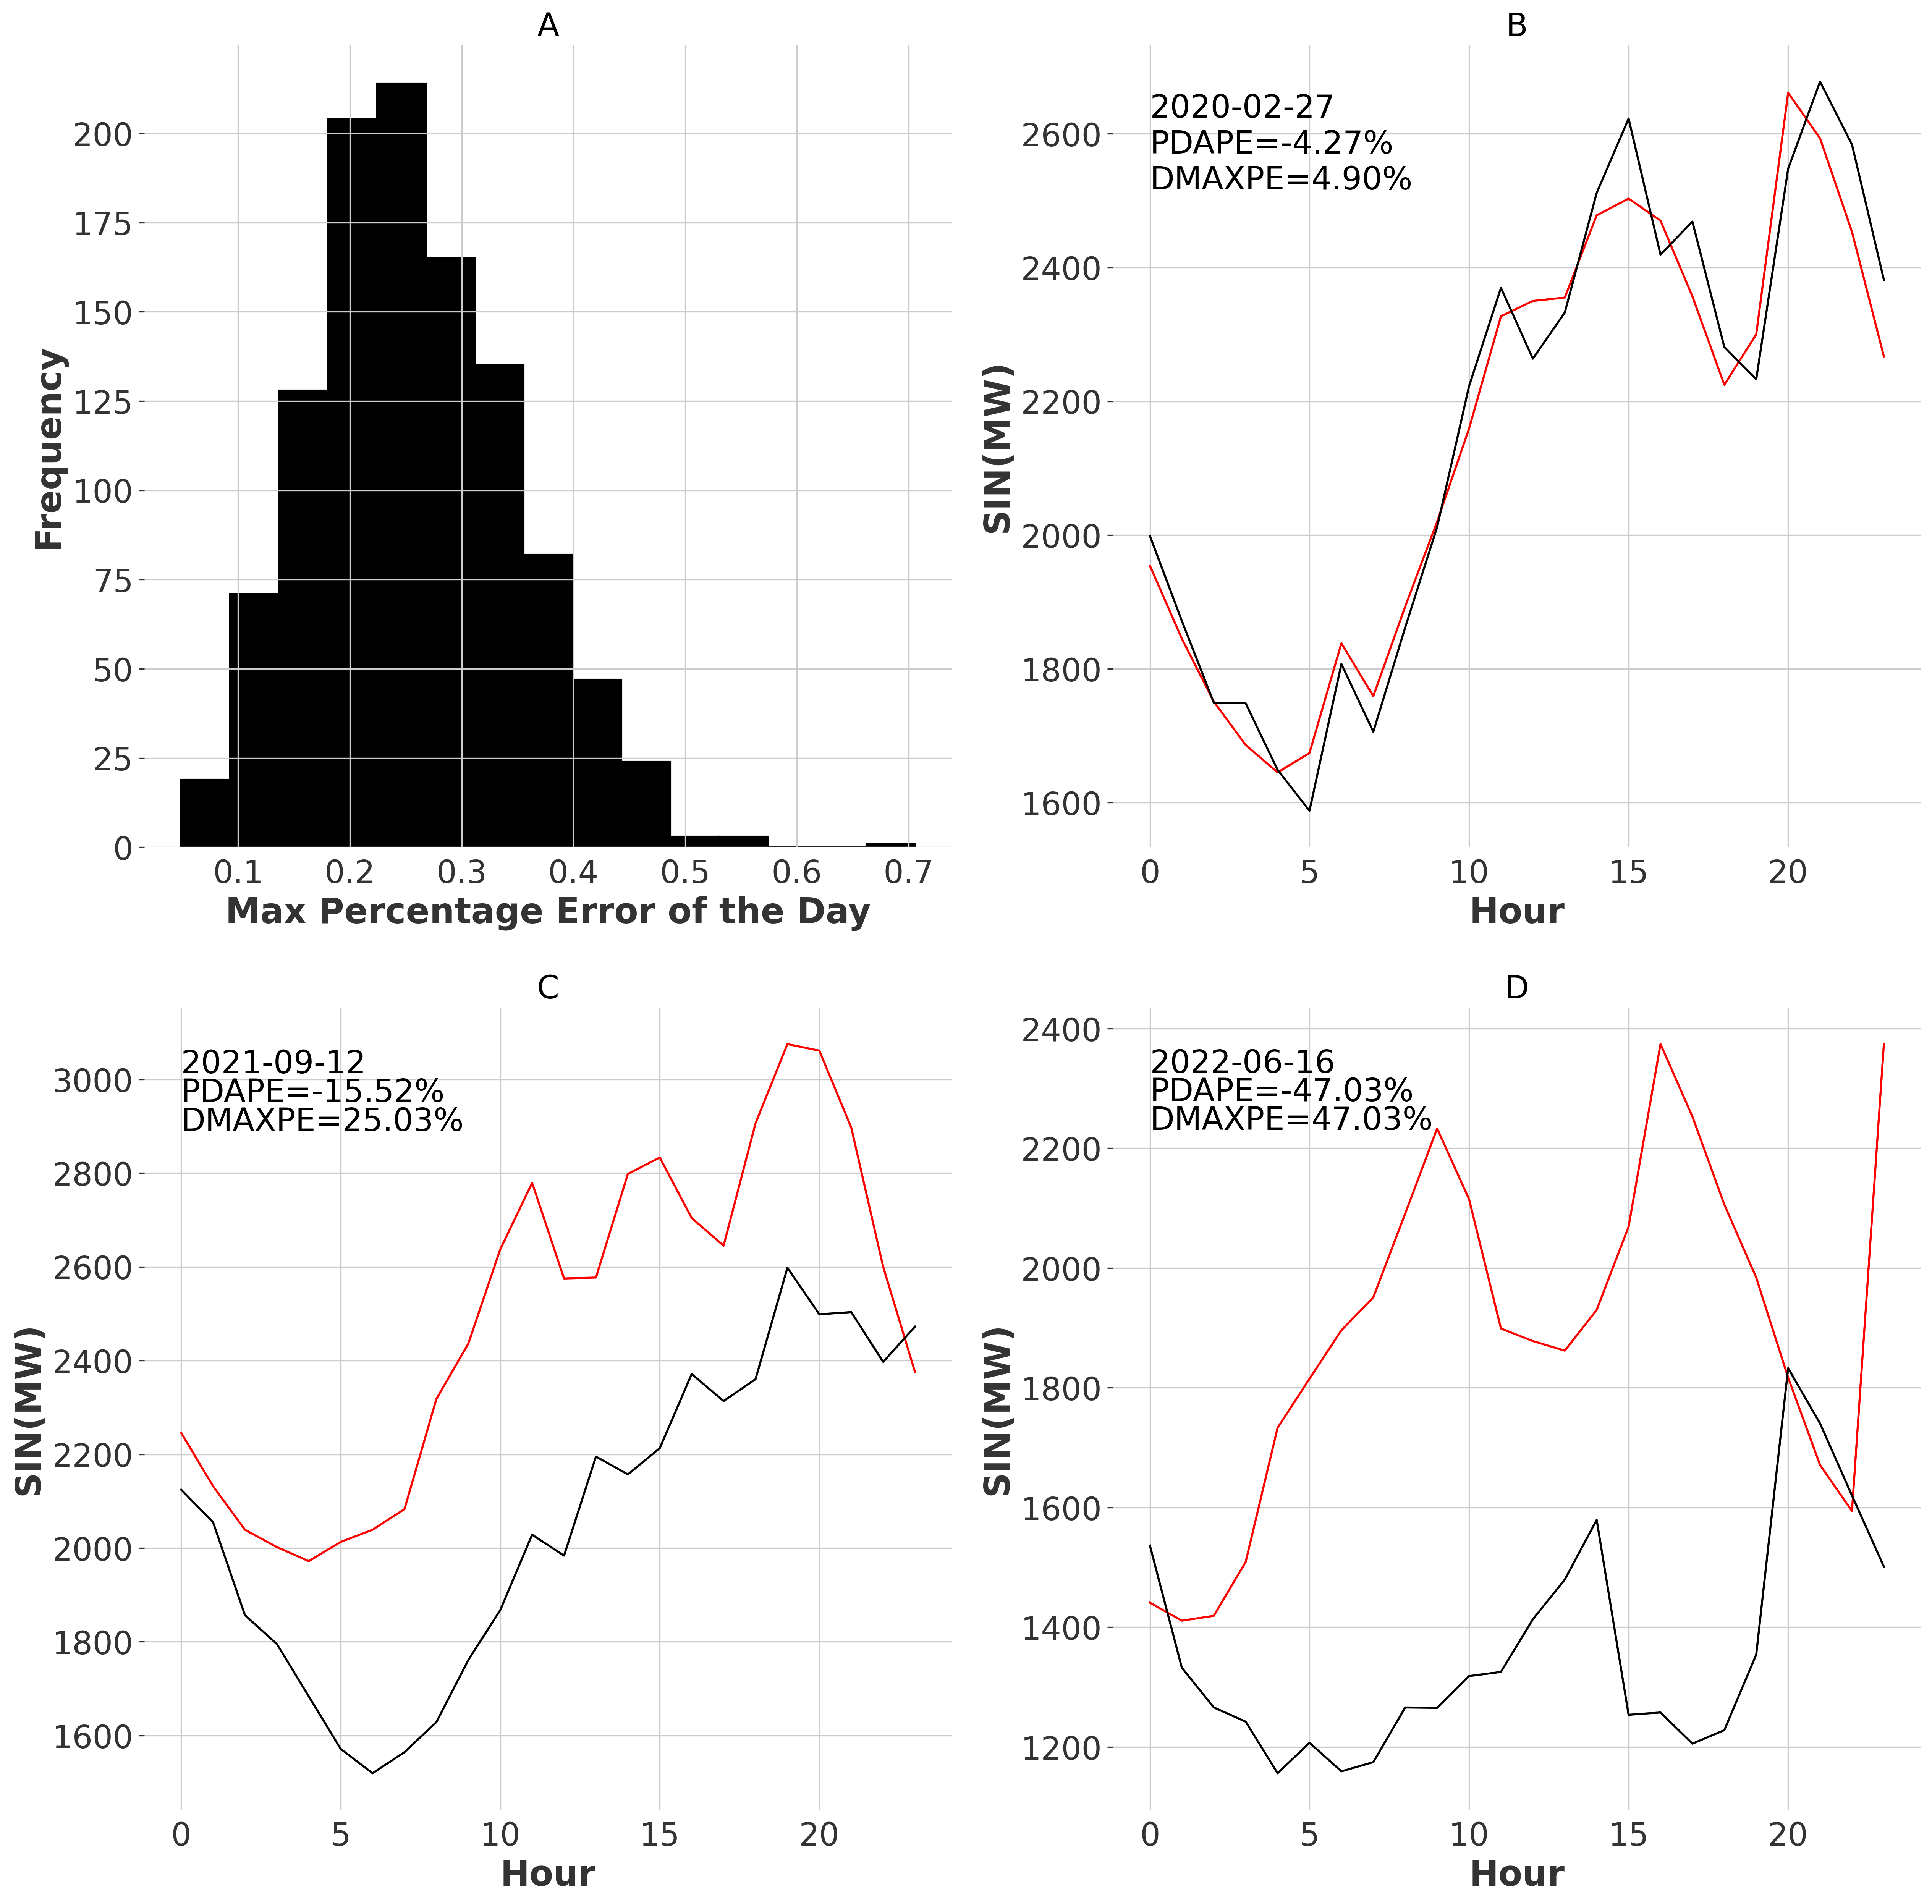

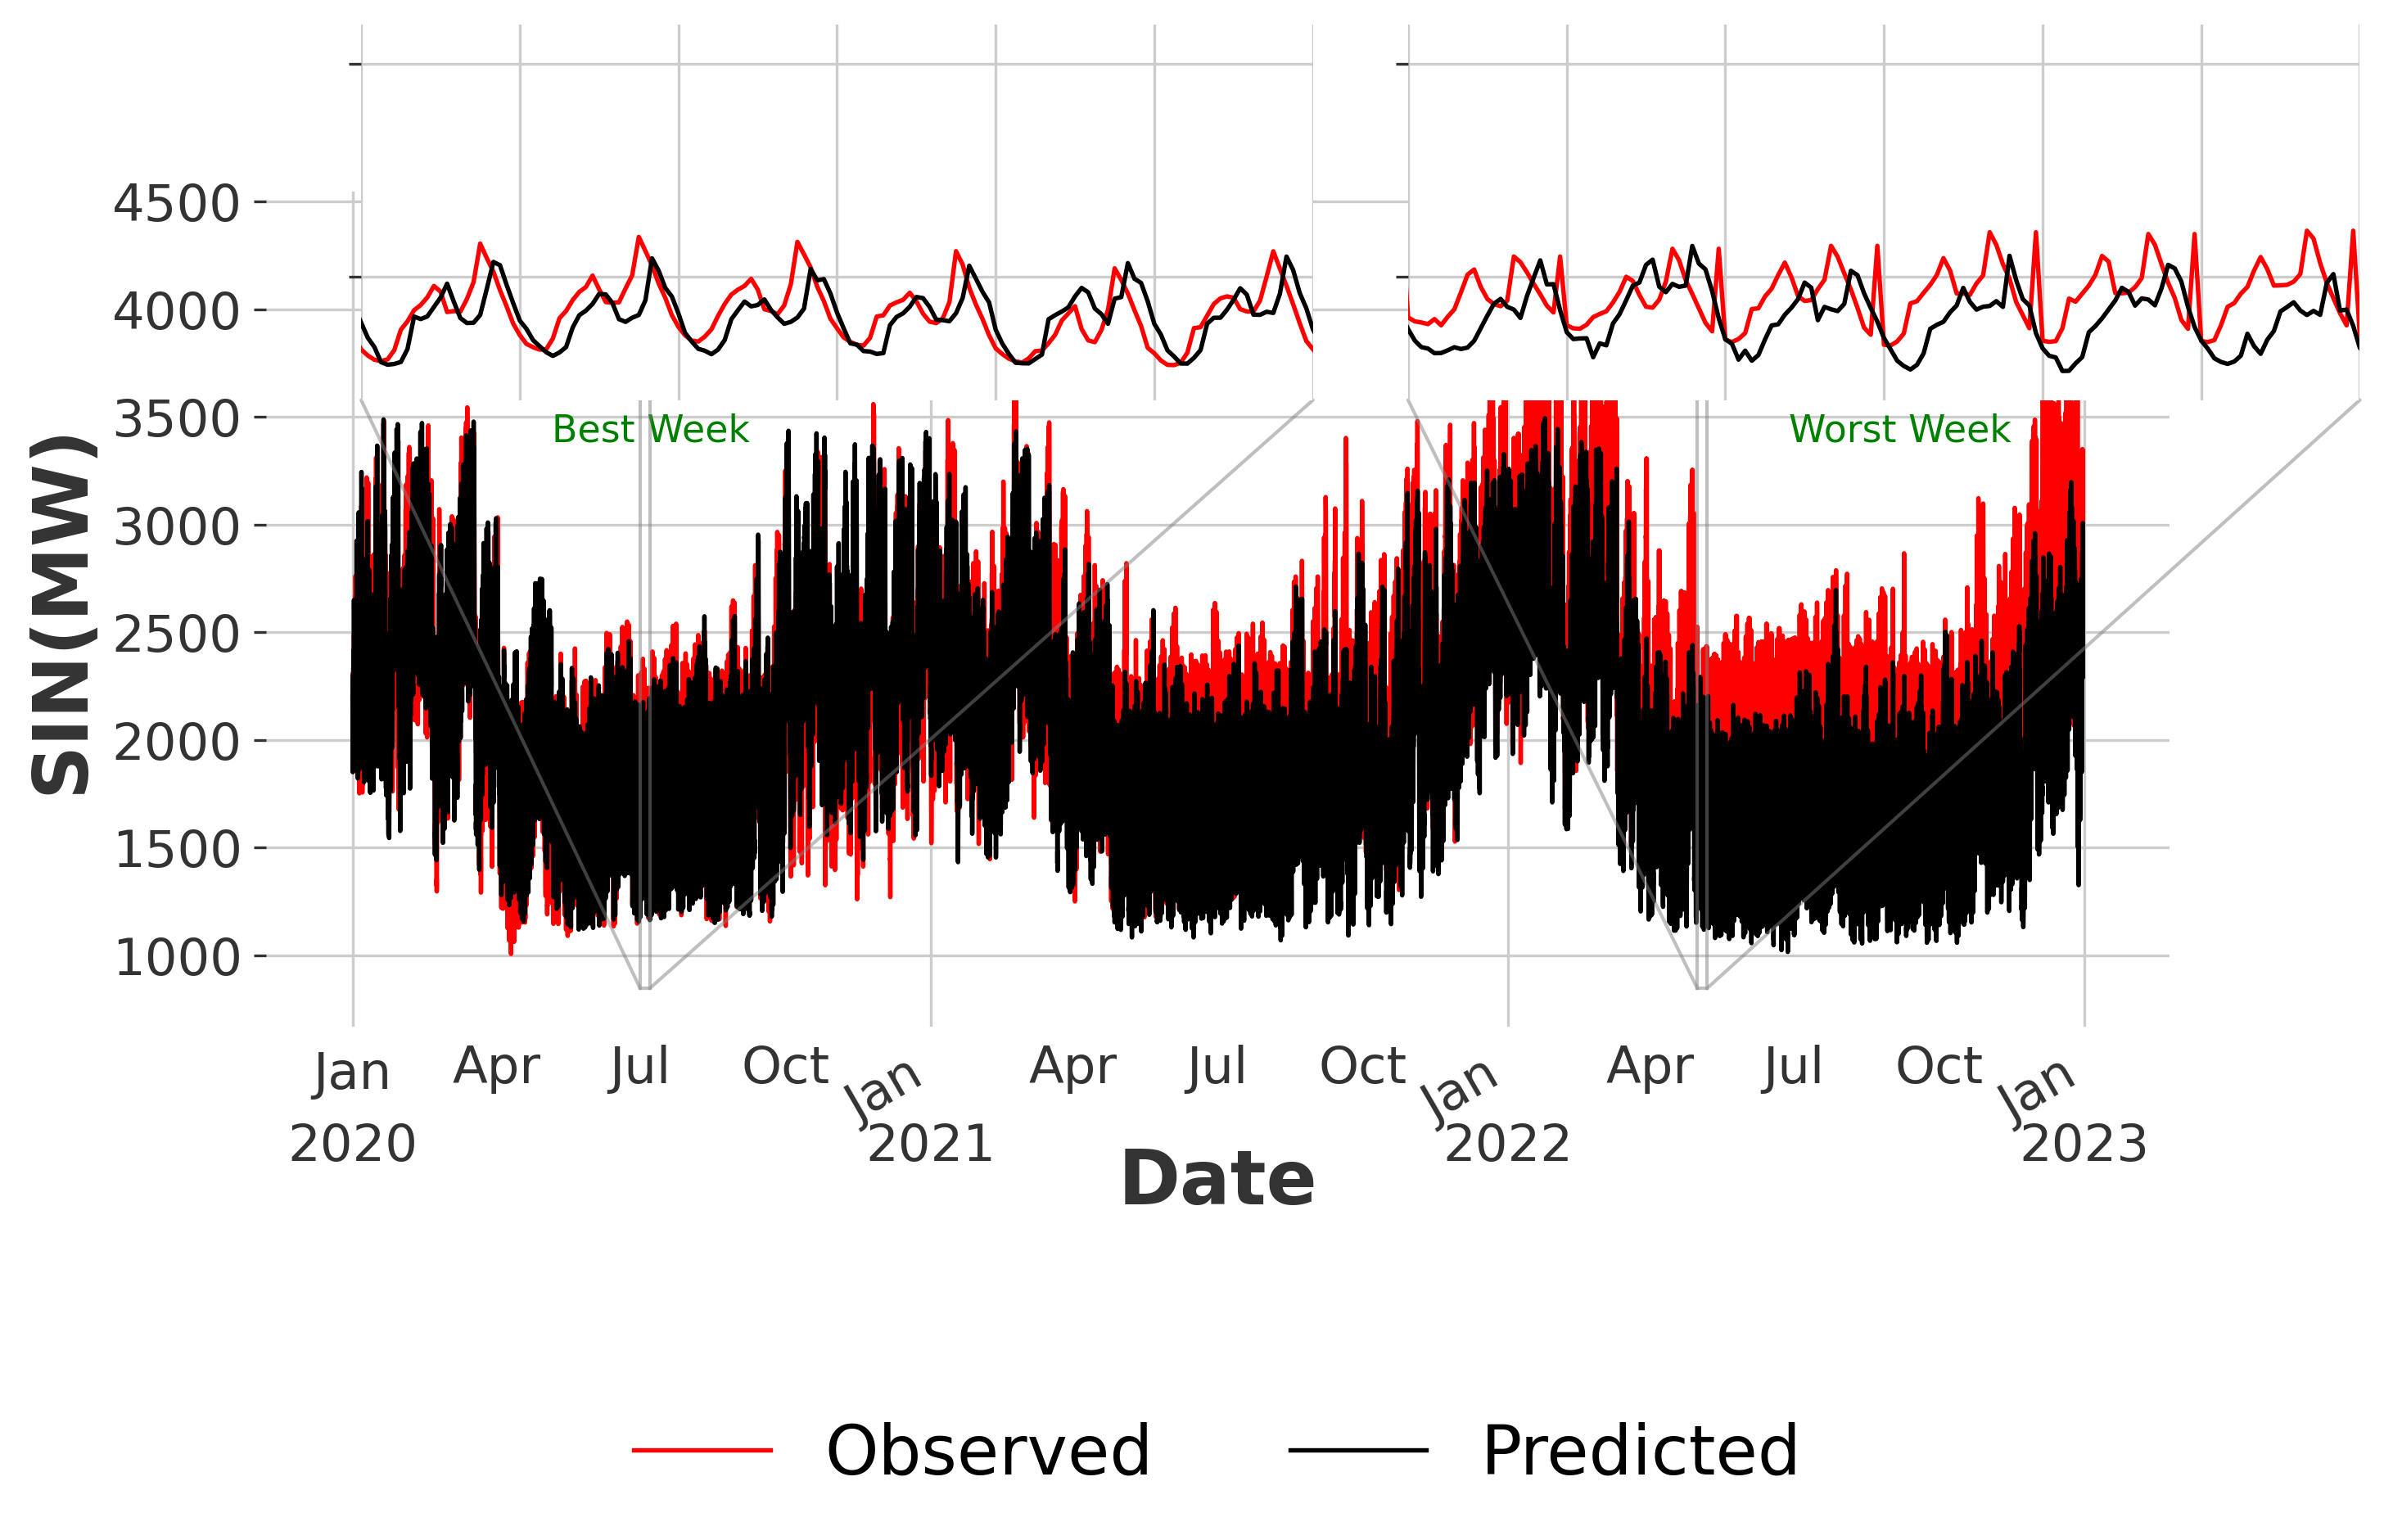

In [52]:
from matplotlib import rcParams
import matplotlib.dates as dates
from matplotlib import dates as mdates

# 2. Configure plot styles
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300
rcParams["font.size"] = 16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"

# 3. Calculate errors

# Assuming you have your predictions and actual values as:
# predictions: The predicted values from Darts
# y_validation: The actual values for validation

# Calculate hmaxerr (Hourly Peak Hour Percentage Error)
# ixmax = np.argmax(val_arr, axis=1)
# hmaxerr = ((tft_pred_val_arr.reshape(-1, 24)[np.arange(tft_pred_val_arr.reshape(-1, 24).shape[0]), ixmax] - np.max(val_arr, axis=1)) / np.max(val_arr, axis=1))

# Calculate maxerr (Max Percentage Error of the Day)
maxerr = np.max(np.abs(tft_pred_val_arr.reshape(-1, 24) - val_arr.reshape(-1, 24)), axis=1) / np.max(val_arr.reshape(-1, 24), axis=1)

print(np.percentile(hmaxerr,99))
print(np.percentile(hmaxerr,50))
print(np.percentile(hmaxerr,1))

fig, axes=plt.subplots(2, 2, figsize=(20, 20))
axes[0, 0].set_title('A')
axes[0, 1].set_title('B')
axes[1, 0].set_title('C')
axes[1, 1].set_title('D')
axes.flatten()[0].hist(hmaxerr,edgecolor="black",bins=15);
axes.flatten()[0].set_xlabel('Hourly Peak Hour Percentage Error')
axes.flatten()[0].set_ylabel('Frequency')
#plt.savefig("testhistrmse.png")

lista=[]
lista.append(np.argmin(np.abs(hmaxerr )))

lista.append(np.argmin(np.abs(hmaxerr - np.percentile(hmaxerr,1))))
lista.append(np.argmin(np.abs(hmaxerr -np.percentile(hmaxerr, 99))))
i=1
for dia in lista:
    maxd=max([np.max(val_arr.reshape(-1,24)[dia,:]),np.max(tft_pred_val_arr.reshape(-1,24)[dia,:])])
    axes.flatten()[i].text(0,maxd*0.98 ,dtin[(dia-1)*24].date().strftime("%Y-%m-%d"))
    axes.flatten()[i].text(0,maxd*0.96 ,"PDAPE="+"{:.2%}".format(hmaxerr[dia]))
    axes.flatten()[i].text(0,maxd*0.94 ,"DMAXPE="+"{:.2%}".format(maxerr[dia]))
    axes.flatten()[i].plot(val_arr.reshape(-1,24)[dia,:],color='red')
    axes.flatten()[i].plot(tft_pred_val_arr.reshape(-1,24)[dia,:])
    axes.flatten()[i].set_xlabel('Hour')
    axes.flatten()[i].set_ylabel('SIN(MW)')

    i=i+1

#fig.savefig("PanelHPE.png")

fig, axes=plt.subplots(2, 2, figsize=(20, 20))
axes[0, 0].set_title('A')
axes[0, 1].set_title('B')
axes[1, 0].set_title('C')
axes[1, 1].set_title('D')

axes.flatten()[0].hist(maxerr,edgecolor="black",bins=15);
axes.flatten()[0].set_xlabel('Max Percentage Error of the Day')
axes.flatten()[0].set_ylabel('Frequency')
#plt.savefig("testhistrmse.png")

lista=[]
lista.append(np.argmin(np.abs(maxerr)))
lista.append(np.argmin(np.abs(maxerr -np.percentile(maxerr, 50))))
lista.append(np.argmin(np.abs(maxerr -np.percentile(maxerr, 99))))
i=1
for dia in lista:
    maxd=max([np.max(val_arr.reshape(-1,24)[dia,:]),np.max(tft_pred_val_arr.reshape(-1,24)[dia,:])])
    axes.flatten()[i].text(0,maxd*0.98 ,dtin[(dia-1)*24].date().strftime("%Y-%m-%d"))
    axes.flatten()[i].text(0,maxd*0.96 ,"PDAPE="+"{:.2%}".format(hmaxerr[dia]))
    axes.flatten()[i].text(0,maxd*0.94 ,"DMAXPE="+"{:.2%}".format(maxerr[dia]))
    axes.flatten()[i].plot(val_arr.reshape(-1,24)[dia,:],color='red')
    axes.flatten()[i].plot(tft_pred_val_arr.reshape(-1,24)[dia,:])
    axes.flatten()[i].set_xlabel('Hour')
    axes.flatten()[i].set_ylabel('SIN(MW)')
    i=i+1

#fig.savefig("PanelMAERR.png")


print(np.percentile(maxerr,99))
print(np.percentile(maxerr,50))
print(np.percentile(maxerr,1))


fig, ax = plt.subplots(figsize=(10, 5))
fmt_month = mdates.MonthLocator(interval=3)
    # Minor ticks every year.
fmt_year = mdates.YearLocator()
ax.xaxis.set_minor_locator(fmt_month)
    # '%b' to get the names of the month
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    # fontsize for month labels
ax.tick_params(labelsize=15, which='both')
    # create a second x-axis beneath the first x-axis to show the year in YYYY format
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide the second x-axis spines and ticks
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)
ax.plot(dtin,val_arr.reshape(-1)[:len(dtin)],color='red',label='Observed')
ax.plot(dtin, tft_pred_val_arr[:len(dtin)],label='Predicted')
# Set the x-axis label
ax.set_xlabel('Date')

# Set the y-axis label
ax.set_ylabel('SIN(MW)')
zoom_start =  pd.to_datetime('2020-07-01')
zoom_end =  pd.to_datetime('2020-07-07')
axins = ax.inset_axes([0.05, 0.75, 0.5, 0.45])  # Adjust the position and size of the zoomed-in box
axins.plot(dtin,val_arr.reshape(-1)[:len(dtin)], color='red',label='Observed')
axins.plot(dtin, tft_pred_val_arr[:len(dtin)], label='Predicted')
axins.set_xlim(zoom_start, zoom_end)
#axins.set_ylim(-2, 2)
axins.set_xticklabels([])
axins.set_yticklabels([])

# Add a box and annotate the zoomed-in region
ax.indicate_inset_zoom(axins)
ax.annotate('Best Week', xy=(0.15, 0.7), xycoords='axes fraction', fontsize=11, color='green')

zoom_start =  pd.to_datetime('2022-05-01')
zoom_end =  pd.to_datetime('2022-05-07')
axins = ax.inset_axes([0.6, 0.75, 0.5, 0.45])  # Adjust the position and size of the zoomed-in box
axins.plot(dtin,val_arr.reshape(-1)[:len(dtin)], color='red',label='Observed')
axins.plot(dtin, tft_pred_val_arr[:len(dtin)], label='Predicted')
axins.set_xlim(zoom_start, zoom_end)
#axins.set_ylim(-2, 2)
axins.set_xticklabels([])
axins.set_yticklabels([])

# Add a box and annotate the zoomed-in region
ax.indicate_inset_zoom(axins)
ax.annotate('Worst Week', xy=(0.8, 0.7), xycoords='axes fraction', fontsize=11, color='green')

# Show the legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2)

# Adjust the layout to prevent overlapping labels
fig.autofmt_xdate()

#fig.savefig("Prediction.png")
# Display the plot


In [57]:
import optuna
from darts.metrics import rmse
def objective(trial):
    # Hyperparameters to be tuned
    input_chunk_length = trial.suggest_int("input_chunk_length", 100, 500, step=50)
    output_chunk_length = trial.suggest_int("output_chunk_length", 12, 48, step=12)

    # Define and train the TFT model
    tft = TFTModel(input_chunk_length=input_chunk_length, output_chunk_length=output_chunk_length)
    tft.fit(train_transformed, future_covariates=covariates_transformed)

    # Predict and calculate RMSE
    tft_pred = tft.predict(n=24, future_covariates=covariates_transformed)
    tft_pred = transformer.inverse_transform(tft_pred)
    error = rmse(val[:24], tft_pred)

    return error

In [58]:
# study = optuna.create_study(direction='minimize')  # We aim to minimize RMSE
# study.optimize(objective, n_trials=10)  # number of trials can be adjusted based on computational capacity

# best_params = study.best_params
# print(f"The best parameters are {best_params} with a RMSE of {study.best_value}.")